In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pickle

import os
from helpers.datasets import *
from helpers.plotting import *

plt.style.use("science.mplstyle")
cm = matplotlib.cm.get_cmap('Greens')
from matplotlib.backends.backend_pdf import PdfPages as pp

np.random.seed(8)

In [2]:
# directories
feta_dir = "/global/home/users/rrmastandrea/FETA/"

STS_config_string = f"LHCO_STS/"
STS_dir = os.path.join(feta_dir, STS_config_string, "data")
os.makedirs(STS_dir, exist_ok=True)

In [3]:
# dataset generation parameters
context_endpoints = (2500, 4500)


bands_dict = {"ob1": [2500, 2900],
              "sb1": [2900, 3300],
              "sr" : [3300, 3700],
              "sb2": [3700, 4100],
              "ob2": [4100, 4500]}


print("Generating datasets...")

bands_to_analyze = ["sb1", "sr", "sb2"]

df_sim = get_lhco(sim_type = "herwig")
data_sim = select_lhco_features(df_sim, feature_type = 0).to_numpy()

df_dat = get_lhco(sim_type = "pythia")
data_dat = select_lhco_features(df_dat, feature_type = 0).to_numpy()

df_signal = get_lhco(sim_type = "pythia", sm = "signal")
data_signal = select_lhco_features(df_signal, feature_type = 0).to_numpy()

# add an extra column to keep track of sig, bkg information
data_sim = np.hstack((data_sim, np.zeros((len(data_sim), 1))))
data_dat = np.hstack((data_dat, np.zeros((len(data_dat), 1))))
data_signal = np.hstack((data_signal, np.ones((len(data_signal), 1))))

print("SIM shape:", data_sim.shape)
print("DAT shape:", data_dat.shape)
print("SIGNAL shape:", data_signal.shape)

n_features = 6

Generating datasets...
events_anomalydetection_herwig_features.h5
events_anomalydetection_v2.features.h5
events_anomalydetection_v2.features.h5
SIM shape: (999986, 7)
DAT shape: (999881, 7)
SIGNAL shape: (99966, 7)


In [4]:
def pull_from_mass_range(dataset, mass_ranges):

        """
        mass_ranges is a list of lists [low_bound, high_bound]
        """

        selected_data = []

        for mass_range in mass_ranges:
            loc = np.where((dataset[:, 5] >= mass_range[0]) & (dataset[:, 5] < mass_range[1]))[0]
            selected_data.append( dataset[loc, :] )
        selected_data = np.concatenate(selected_data)
        np.random.shuffle(selected_data)

        return selected_data

def pull_n_signal_events(n, sig_dataset):
    
    selected_sig_indices = np.random.choice(sig_dataset.shape[0], size=n, replace=False)
    selected_sig_events = sig_dataset[selected_sig_indices]
    
    return(selected_sig_events)

## Count number of events ber band

In [5]:
herwig_bkg_dict = {}
pythia_bkg_dict = {}
pythia_sig_dict = {}

num_sig_pythia_events = {}
num_bkg_pythia_events = {}

for b in bands_to_analyze:
    print(f"Number of events in band {b}:")
    loc = pull_from_mass_range(data_sim, [bands_dict[b]])
    herwig_bkg_dict[b] = loc
    print(f"Herwig bkg: {len(loc)}")
    
    loc = pull_from_mass_range(data_dat, [bands_dict[b]])
    pythia_bkg_dict[b] = loc
    num_bkg_pythia_events[b] = len(loc)
    print(f"Pythia bkg: {len(loc)}")
    
    loc = pull_from_mass_range(data_signal, [bands_dict[b]])
    pythia_sig_dict[b] = loc
    num_sig_pythia_events[b] = len(loc)
    print(f"Pythia sig: {len(loc)}")
          
    print()



Number of events in band sb1:
Herwig bkg: 210767
Pythia bkg: 212115
Pythia sig: 11565

Number of events in band sr:
Herwig bkg: 121978
Pythia bkg: 121339
Pythia sig: 75299

Number of events in band sb2:
Herwig bkg: 68609
Pythia bkg: 66646
Pythia sig: 8842



## Pull from sb1 -> sb2 to visualize and get column rescales

SIM shape: (401354, 7)
DAT shape: (400100, 7)
SIGNAL shape: (95706, 7)


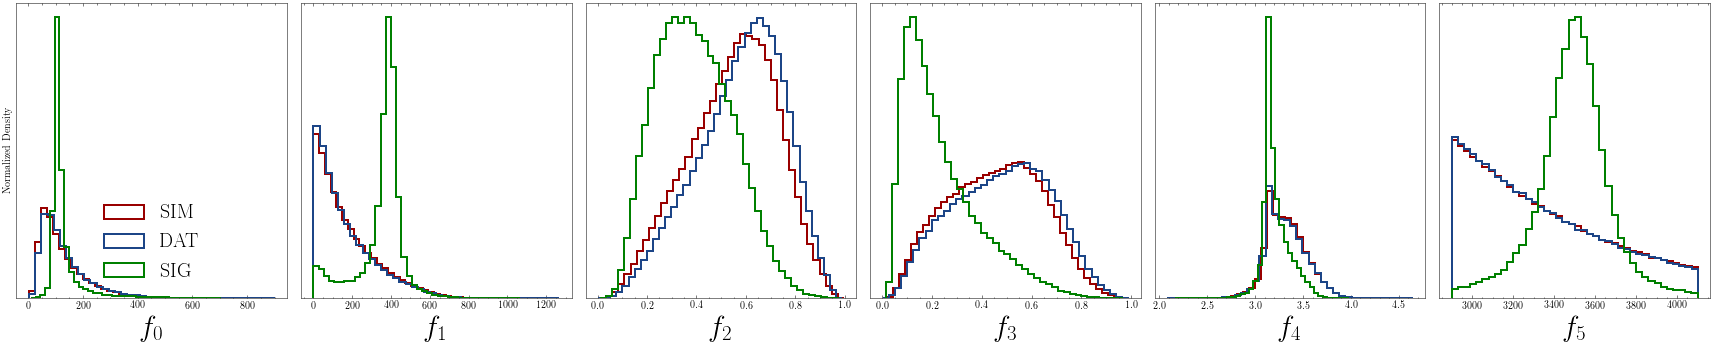

In [6]:
pulls = [bands_dict[b] for b in bands_to_analyze]

in_range_herwig_bkg = pull_from_mass_range(data_sim, pulls)
in_range_pythia_bkg = pull_from_mass_range(data_dat, pulls)
in_range_pythia_sig = pull_from_mass_range(data_signal, pulls)


# list of (min, max) to preprocess every column
col_minmax = []
for col in range(n_features):
    col_minmax.append([np.min(in_range_herwig_bkg[:, col]), np.max(in_range_herwig_bkg[:, col])])
    

print("SIM shape:", in_range_herwig_bkg.shape)
print("DAT shape:", in_range_pythia_bkg.shape)
print("SIGNAL shape:", in_range_pythia_sig.shape)

feature_labels = [r"$f_0$", r"$f_1$", r"$f_2$", r"$f_3$", r"$f_4$", r"$f_5$"]

# Plot some features
fig = plot_feature_histograms(in_range_herwig_bkg, in_range_pythia_bkg, 40, n_features, feature_labels, 
                              third_plot = in_range_pythia_sig)
fig.show()



## Generate a standard test set and write out

This is the first 20k signal, 20k background events IN THE SR


(20000, 6) (20000, 6)


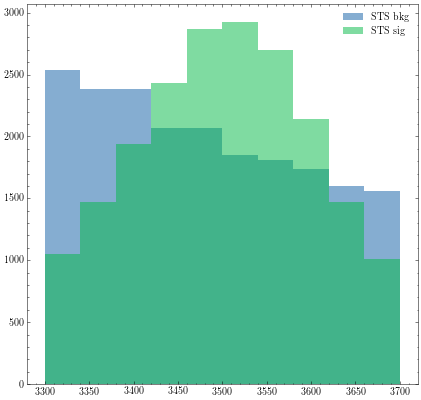

[6.32058983e+01 7.13900948e+01 6.10356791e-01 4.37379758e-01
 3.51498614e+00 3.48222516e+03]
[6.15778008e+01 2.14976997e+01 7.14002861e-01 6.67484140e-01
 3.53940192e+00 3.35226632e+03]
[2.67096985e+02 3.00035034e+02 3.98741046e-01 1.07757757e-01
 3.11928623e+00 3.57810608e+03]
[2.41292007e+02 2.30059982e+02 5.96344795e-01 1.46144544e-01
 3.57879613e+00 3.57843323e+03]


In [7]:
n_sts = 20000

sts_bkg = pythia_bkg_dict["sr"][:n_sts,:-1]
sts_sig = pythia_sig_dict["sr"][:n_sts,:-1]

print(sts_bkg.shape, sts_sig.shape)


plt.figure()
plt.hist(sts_bkg[:,-1], alpha = 0.5, label = "STS bkg")
plt.hist(sts_sig[:,-1], alpha = 0.5, label = "STS sig")
plt.legend()
plt.show()

print(sts_bkg[0])
print(sts_bkg[1])
print(sts_sig[0])
print(sts_sig[1])

In [8]:
np.save(os.path.join(STS_dir, "STS_bkg.npy"), sts_bkg)
np.save(os.path.join(STS_dir, "STS_sig.npy"), sts_sig)
np.save(os.path.join(STS_dir, "col_minmax.npy"), col_minmax)

## Generate the supervised dataset

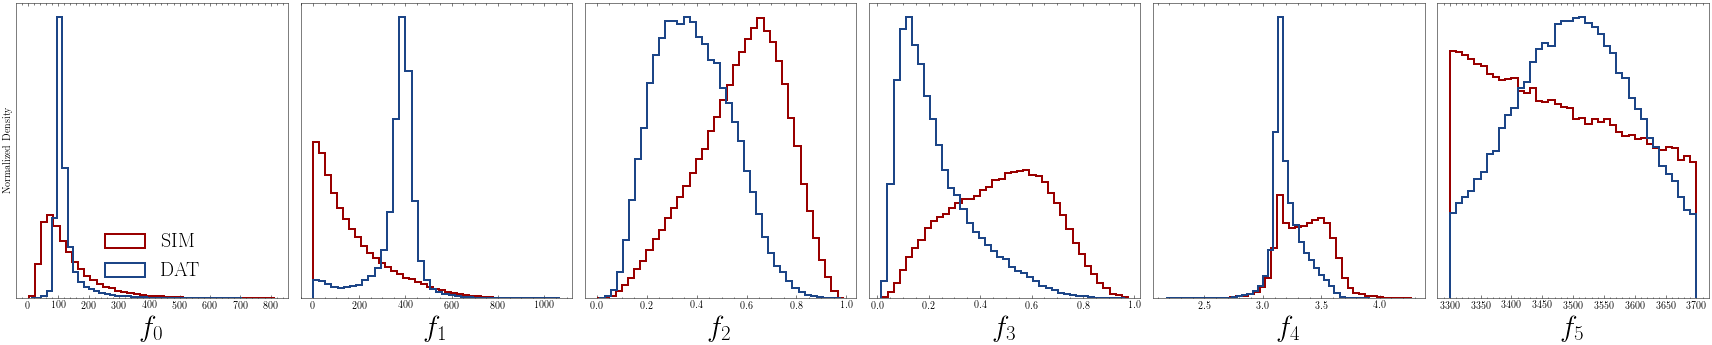

In [9]:

true_sup_bkg = pythia_bkg_dict["sr"][n_sts:,:-1]
true_sup_sig = pythia_sig_dict["sr"][n_sts:,:-1]

feature_labels = [r"$f_0$", r"$f_1$", r"$f_2$", r"$f_3$", r"$f_4$", r"$f_5$"]


fig = plot_feature_histograms(true_sup_bkg, true_sup_sig, 40, n_features, feature_labels)
fig.show()

np.save(os.path.join(STS_dir, "true_sup_bkg.npy"), true_sup_bkg)
np.save(os.path.join(STS_dir, "true_sup_sig.npy"), true_sup_sig)


## Save out the nonSTS

This is a little subtle because although we only pulled the STS from the SR, we need to save out only a portion of the SB to get the proper ratios of events in SB1/SR/SB2

In [10]:
pythia_bkg_nonSTS = {}
pythia_sig_nonSTS = {}

frac_pythia_sig_dropped = n_sts / num_sig_pythia_events["sr"]
frac_pythia_bkg_dropped = n_sts / num_bkg_pythia_events["sr"]


for b in bands_to_analyze:
    num_drop_bkg = int(frac_pythia_bkg_dropped*num_bkg_pythia_events[b])
    pythia_bkg_nonSTS[b] = pythia_bkg_dict[b][num_drop_bkg:]
    print(f"Dropping {num_drop_bkg} bkg events from band {b}")
    
    
    num_drop_sig = int(frac_pythia_sig_dropped*num_sig_pythia_events[b])
    pythia_sig_nonSTS[b] = pythia_sig_dict[b][num_drop_sig:]
    print(f"Dropping {num_drop_sig} sig events from band {b}")
    

pickle.dump( herwig_bkg_dict, open( "post_STS/herwig_bkg_dict.p", "wb" ) )
pickle.dump( pythia_bkg_nonSTS, open( "post_STS/pythia_bkg_nonSTS.p", "wb" ) )
pickle.dump( pythia_sig_nonSTS, open( "post_STS/pythia_sig_nonSTS.p", "wb" ) )






Dropping 34962 bkg events from band sb1
Dropping 3071 sig events from band sb1
Dropping 20000 bkg events from band sr
Dropping 20000 sig events from band sr
Dropping 10985 bkg events from band sb2
Dropping 2348 sig events from band sb2
